In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2023-11-16 22:24:28.337525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'sklearn'

# Autoencoder

En esta sección, nos sumergiremos en los cimientos del procesamiento de datos mediante la arquitectura de autoencoder clásico. Los autoencoders, una forma fundamental de redes neuronales, han demostrado ser una herramienta esencial en la extracción y representación de características de datos complejos. A lo largo de esta sección, desglosaremos los componentes esenciales de un autoencoder y examinaremos cómo este enfoque puede usarse para lograr la compresión de datos y la extracción de características.

Comenzaremos por comprender el diseño básico de un autoencoder, explorando su estructura en forma de codificador y decodificador. Investigaremos cómo estos componentes trabajan en conjunto para capturar las características más relevantes y comprimir la información contenida en los datos de entrada. A medida que profundicemos en el proceso de entrenamiento, aprenderemos cómo el autoencoder minimiza la diferencia entre la entrada original y la salida reconstruida, mejorando la capacidad del modelo para capturar patrones y detalles.

## ¿Que es un autoencoder?

    

# Autoencoder básico

Primeramente haremos el modelo más simple de autoenco

In [6]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0237 - val_loss: 0.0131
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

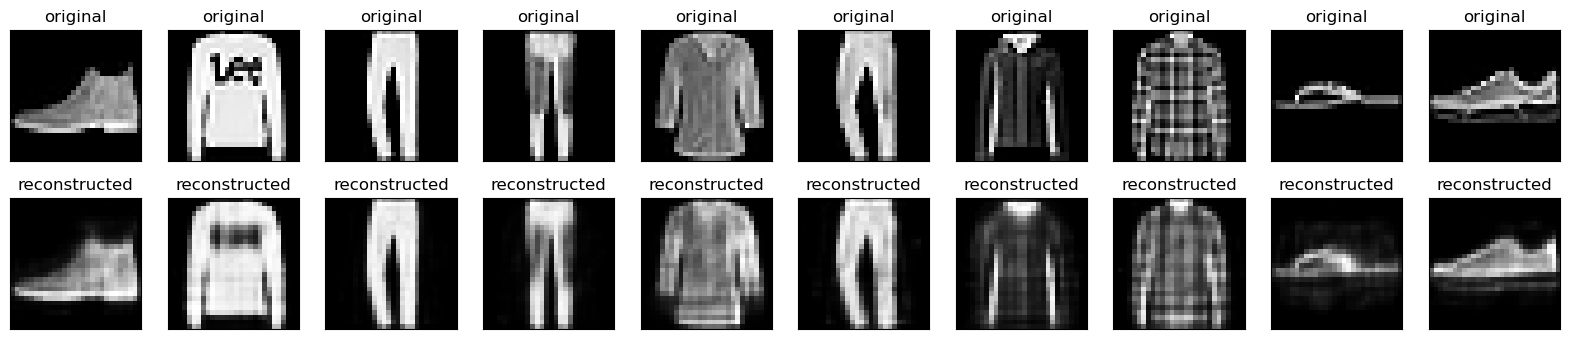

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional autoencoder


Aquí vamos a ver un convolutional autoencoder para la eliminación de ruido.

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

NameError: name 'x_train' is not defined

In [8]:
# Añadimos ruido a la imagen 


noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [9]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [10]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [11]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 213s 113ms/step - loss: 0.0164 - val_loss: 0.0100
Epoch 2/10
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 3/10
1875/1875 [==============================] - 241s 128ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 4/10
1875/1875 [==============================] - 250s 134ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 5/10
1875/1875 [==============================] - 304s 162ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 230s 123ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 8/10
1875/1875 [==============================] - 242s 129ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 9/10
1875/1875 [==============================] - 250s 133ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/10
1875/1875 [=======================

In [12]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

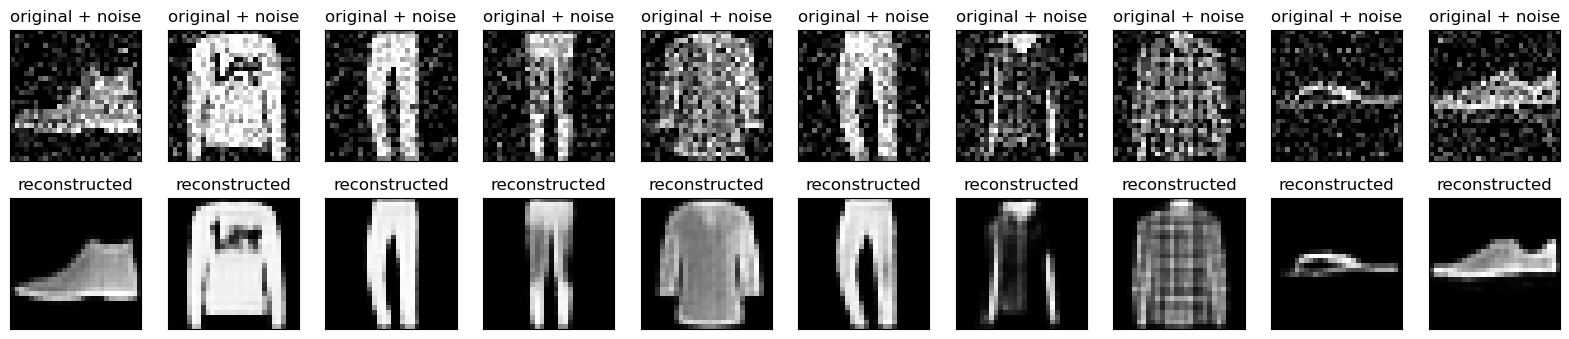

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Variational autoencoder

Aquí vemos cómo  entrenar un codificador automático variacional (VAE) ( 1 , 2 ) en el conjunto de datos MNIST. Un VAE es una versión probabilística del codificador automático, un modelo que toma datos de entrada de alta dimensión y los comprime en una representación más pequeña. A diferencia de un codificador automático tradicional, que asigna la entrada a un vector latente, un VAE asigna los datos de entrada a los parámetros de una distribución de probabilidad, como la media y la varianza de una Gaussiana. Este enfoque produce un espacio latente estructurado continuo, que es útil para la generación de imágenes.